## Dimensions
1. Number of clusters (3,5,7,9)
2. Cluster validity index (DBIndex, Silhoutte Index, Dunn Index)
3. Algorithms (Genetic, Particle Swarm, Particle Gray Wolf)
4. Datasets (BBC, BBC Sports, Reuters, 20 newsgroup, etc.)

In [1]:
import nltk
import os
import re
import math
import pandas as pd
import numpy as np
import copy
import string
import random
import itertools
import time
import csv
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import statistics
from mpl_toolkits.mplot3d import axes3d, Axes3D
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import Normalizer
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix

Time to pre-process : 2.234375
[[ 0.67371995 -0.28140335  0.68331075]
 [ 0.92167752  0.12353328  0.3677636 ]
 [ 0.64803766 -0.28078109  0.70796128]
 ...
 [ 0.8132671  -0.22234338  0.53773604]
 [ 0.96655002 -0.19503999  0.16655468]
 [ 0.83041172 -0.11264946  0.54564317]]


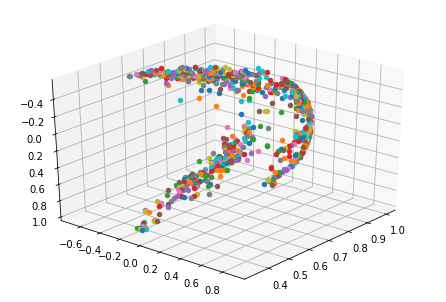

In [2]:
all_texts=[]
Y = []
dictionary= {}
start = time.process_time()
os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbcsport")
# os.chdir("C://Users//Hp//Desktop//Projects//Text-Mining//bbc")
directories = os.listdir()
label = 0
for directory in directories:
    path = os.path.join(os.getcwd(),directory)
    os.chdir(path)
    files = os.listdir()
    temp = []
    for file in files:
        with open(file,'r') as curr_file:
            all_texts.append(curr_file.read())
            Y.append(label)
    label = label + 1
    os.chdir('..')
os.chdir('..')
path = os.path.join(os.getcwd(),"GA")
os.chdir(path)
tfidf = TfidfVectorizer(all_texts, stop_words='english')
vectors = tfidf.fit_transform(all_texts)
all_words = tfidf.get_feature_names()
vectors_dense = vectors.todense()
svd = TruncatedSVD(n_components=3)
vectors_dense_svd = svd.fit_transform(vectors_dense)
vectors_dense_svd = Normalizer().fit_transform(vectors_dense_svd)
end = time.process_time()
print("Time to pre-process : "+str(end-start))
fig=plt.figure()
X = vectors_dense_svd
ax = Axes3D(fig)
print(X)
for j in range(len(X)):
    temp = ' '.join(map(str, X[j]))
    dictionary[temp]=Y[j]
    ax.scatter(X[j][0], X[j][1], X[j][2], marker='o')
    ax.view_init(330, 140)

In [3]:
K=7
P=30
cross_over_rate=0.1
mutation_rate=0.01
number_of_generations=100

In [4]:
def population_initialization():
    '''
    Parameters:
    Output:
        P chromosomes of length K*N where N is the number of features
    Function:
        Takes K random datapoints from the dataset and appends them to create a chromosome
        This is repeated P times
    '''
    population=[]
    for i in range(P):
        chromosome=[]
        for j in range(K):
            chromosome.append(X[random.randint(0,len(X)-1)])
        chromosome=list(itertools.chain(*chromosome))
        population.append(chromosome)
    return population

In [5]:
#Function to decide cluster using Euclidean distance
def cosine_similarity(centers,datapoint):
    '''
    Parameters:
        centers: List of Cluster centers
        K : number of clusters
        datapoint : Datapoint
    Output:
        Cluster number alloted based on maximum cosine_similarity of the datapoint with the cluster centers
    '''
    #Cosine Similarity    
    t = np.asarray(datapoint)
    normt= np.linalg.norm(t)
    dot=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        normc = np.linalg.norm(temp_center)
        cos_sim_value=np.dot(t,temp_center)/(normt*normc)
        dot.append(cos_sim_value)
    
    return dot.index(max(dot))

In [6]:
def euclidean_dist_based_center_decision(centers,datapoint):
    t = np.asarray(datapoint)
    dist=[]
    for i in range(K):
        temp_center = np.asarray(centers[i])
        dist.append(np.sqrt(np.sum(np.square(temp_center-t))))
    return dist.index(min(dist))

In [7]:
def fitness_function(chromosome):
    '''
    Parameters:
        K: Number of clusters
        chromosome: Contains the centers of K clusters
        X : dataset
    Output:
        A fitness value f for the input chromosome
    Function:
        1. Initializes K centers using the chromosome
        2. Divides the dataset into K clusters using functions like cosine_similarity or euclidean_distance
        3. Recomputer cluster centers by averaging the datapoints of that cluster
        4. Computer fitness value as follows:
                M = sum from i in range(1,K)(Mi)
                Mi= sum of distances of datapoints of a cluster from its center
                fitness_value(f) = 1/M
    '''
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
    
    n_components=2
    svd = TruncatedSVD(n_components)
    U  = []
    for i in range(K):
        if(len(clusters[i])!=0):
            U.append(svd.fit_transform(clusters[i]))
    
    theta=0
    for i in range(n_components):
        for j in range(len(U)):
            for k in range(len(U)):
                if k!=j and (U[k].shape)[1]==(U[j].shape)[1]:
                    t1 = U[j][i]
                    t2 = U[k][i]
                    temp = np.dot(t1,t2)/(np.linalg.norm(t1)*np.linalg.norm(t2))
                    theta=theta+math.acos(temp)
        
    #Recomputing cluster centers
    centers=[]
    for i in range(K):
        temp=clusters[i]
        if len(temp)!=0:
            centers.append((np.sum(np.asarray(temp),axis=0)/len(temp)).tolist())
        else:
            temp_list=X[random.randint(0,len(X)-1)]
            centers.append(temp_list)
    
    chromosome =[]
    for i in range(len(centers)):
        chromosome.extend(centers[i])
    fitness_score = theta
    return fitness_score,chromosome        

In [8]:
def fitness_evaluation(population):
    '''
    Parameters:
        K: Number of clusters
        population: Contains all the chromosomes of the current generation
        X : dataset
    Output:
        A list of fitness scores of each chromosome in the parent
    '''
    fitness=[]
    pop = []
    for i in population:
        fitness_value,recomputed_chromosome = fitness_function(i)
        fitness.append(fitness_value)
        pop.append(recomputed_chromosome)
    return pop,fitness

In [9]:
def roulette_wheel(fitness_scores):
    sum_fitness_scores = np.sum(np.asarray(fitness_scores))
    temp_fitness = copy.deepcopy(fitness_scores)
    temp_fitness.sort(reverse=True)
    t=[]
    for i in range(len(fitness_scores)):
        percentage_coverage=int(temp_fitness[i]*360/sum_fitness_scores)
        for j in range(percentage_coverage):
            t.append(i)
    
    temp=[]
    for i in range(2):
        toss=random.randint(0,len(t)-1)
        temp.append(t[toss])
    return temp

In [10]:
def cross_over(parent1,parent2,parent1_f_val,parent2_f_val):
    temp = {}
    fitness_scores=[]
    fitness_scores.append(parent1_f_val)
    fitness_scores.append(parent2_f_val)
    temp[parent1_f_val]=parent1
    temp[parent2_f_val]=parent2
    for i in range(1,len(parent1)-1):
        prob_of_cross_over_point = np.random.random_sample()
        if prob_of_cross_over_point<cross_over_rate:
            left_parent_1 = parent1[:i]
            right_parent_1= parent1[i:]
            left_parent_2 = parent2[:i]
            right_parent_2= parent2[i:]
            child1 = left_parent_1
            child2 = left_parent_2
            child1.extend(right_parent_2)
            child2.extend(right_parent_1)
            _,fitness_values = fitness_evaluation([child1,child2])
            temp[fitness_values[0]]=child1
            temp[fitness_values[1]]=child2
            fitness_scores.extend(fitness_values)
    max1=max(fitness_scores)
    fitness_scores.remove(max1)
    max2=max(fitness_scores)
    return temp[max1],temp[max2]

In [11]:
def cross_over_function(population,fitness_scores):
    '''
    Parameters:
        population: Parent population chromosomes
        fitness_scores: fitness of parent population
    Output:
        children generation population
    Function:
        We select the 2 best chromosomes and 2 worst chromosomes and perform a cross-over between the bests and worsts and add
        them to the population generating children generation population with 4 different chromosomes.
    '''
    for i in range(P//2):
        t=roulette_wheel(fitness_scores)
        t.sort()
        c1i,c2i=t[0:2]
        chromosome1 = population[c1i]
        chromosome2 = population[c2i]

        c1,c2 = cross_over(chromosome1,chromosome2,fitness_scores[c1i],fitness_scores[c2i])

        population.append(c1)
        population.append(c2)

        del(population[c1i])
        del(fitness_scores[c1i])
        c2i=max(0,c2i-1)
        del(population[c2i])
        del(fitness_scores[c2i])

        t,fitness = fitness_evaluation([c1,c2])
        fitness_scores.extend(fitness)
    return population,fitness_scores

In [12]:
def mutation(children):
    '''
    Parameters:
        children: Children we get from the genetic cross-over in the previous stage
        mutation_rate: Rate at which we want to mutate the children (0-1)
    Output:
        children with a mutated gene
    Functions:
        We randomly select a number between 0 and 1 using probably a gaussian distribution as mutation is not a frequent
        phenomenon. If that value is less than mutation_rate we mutate the children.
        For mutation we again generate a value alpha between 0 to 1. We then randomly select a position from the chromosome
        and changes its value as following
            let the value at the randomly selected position be v
            v = v (+/-) 2*alpha*v if(v!=0)
            v = v (+/-) 2*alpha   if(v==0)
        (+/-) is selected randomly giving each a 50-50 chance
    '''
    for i in range(len(children)):
        temp = np.random.rand(1)[0]
        if temp<mutation_rate:
            chromosome = children[i]
            position = random.randint(0,len(chromosome)-1)
            chromosome[position]=abs(1-chromosome[position])
            children[i]=chromosome
            
    return children

Cluster purity measure indexes

In [13]:
def intracluster_distances(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
        clusters[cosine_similarity(centers,X[i])].append(X[i])
   
    intracluster_d=[]
    for i in range(K):
        M=0
        temp=clusters[i]
        center=centers[i]
        for j in temp:
            M+=np.linalg.norm(np.asarray(j)-np.asarray(center))
        if len(temp)==0:
            M=0
        else:
            M=M/len(temp)
        intracluster_d.append(M)
    return intracluster_d

In [14]:
def davies_bouldin_index(chromosome):
    intra_distance = intracluster_distances(chromosome)
    
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    D = []
    for i in range(K):
        R = []
        for j in range(K):
            if i!=j:
                M = np.linalg.norm(np.asarray(centers[i])-np.asarray(centers[j]))
                r = (intra_distance[i]+intra_distance[j])/M
                R.append(r)
        D.append(max(R))
    return (1/K)*(np.sum(np.asarray(D)))

In [15]:
def silhoutette_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])

    S = 0
    for i in range(K):
        for j in clusters[i]:
            a = 0
            b = 0
            t1 = np.asarray(j)
            for k in clusters[i]:
                t2 = np.asarray(k)
                a  = a + np.sqrt(np.sum(np.square(t1-t2)))
            for k in range(K):
                if i!=k:
                    for f in clusters[k]:
                        t2 = np.asarray(f)
                        b  = b + np.sqrt(np.sum(np.square(t1-t2)))
            s = abs(a-b)/max(a,b)
            S = S + s
    S = S/len(X)
    return S

In [16]:
def calinski_harabasz(chromsome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    #1. Calculating SSb:
    SSb = 0
    m = np.mean(X)
    for i in range(K):
        SSb += len(clusters[i])*np.square(np.linalg.norm(centers[i]-m))
    
    #2. Calculating SSw:
    SSw = 0
    for i in range(K):
        for j in clusters[i]:
            SSw += np.square(np.linalg.norm(j-centers[i]))
    
    ch_index = (SSb/SSw)*((len(X)-K)/(K-1))
    return ch_index

In [17]:
def dunn_index(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    numerator = 10000000
    denominator=1
    for i in range(K):
        for j in range(K):
            if i!=j:
                numerator = min(numerator, np.sqrt(np.sum(np.square(np.asarray(centers[i])-np.asarray(centers[j])))))
    
    denominator = max(intracluster_distances(chromosome))
    return numerator/denominator

In [18]:
def supervised_scores(chromosome):
    centers=[]
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
        
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    
    Y_actual=[]
    Y_pred=[]
    for i in range(K):
        t=[]
        for j in range(len(clusters[i])):
            temp = ' '.join(map(str, clusters[i][j]))
            Y_actual.append(dictionary[temp])
            t.append(dictionary[temp])
        print(t)
        pred = statistics.mode(t)
        print(pred)
        for j in range(len(clusters[i])):
            Y_pred.append(pred)
            
    print(confusion_matrix(Y_actual, Y_pred))
    return f1_score(Y, Y_pred, average='micro'), accuracy_score(Y, Y_pred)    

In [19]:
def main_func():
    '''
    Steps:
    Repeat 1-5 till 1 chromosome remains in the population
    1.Initialize Population
    2.Compute fitness scores
    3.Selection
    4.Cross-over
    5.Mutation
    '''
    start = time.process_time()
    population = population_initialization()
    gen=0
    return_chromosome=[]
    gen_fitness = []
    for i in range(number_of_generations):
        gen+=1
        population,fitness=fitness_evaluation(population)
        children,fitness = cross_over_function(population,fitness)
        children = mutation(children)
        population=children
        temp = []
        temp.append(str(gen))
        temp.append(str(max(fitness)))
        gen_fitness.append(temp)
        print("Generation: "+str(gen)+" | Best fitness: "+str(max(fitness)))
    end = time.process_time()
    print("Time taken: " + str(end-start))
    with open('GA with K='+str(K)+'.csv','w+') as csvFile:
        writer = csv.writer(csvFile)
        writer.writerows(gen_fitness)
    csvFile.close()
    return population[fitness.index(max(fitness))]

In [20]:
def plot(chromosome):
    centers=[]
    
    #Dividing the chromosomes into centers
    for i in range(K):
        centers.append(chromosome[i*len(X[0]):len(X[0])*(i+1)])
    
    #Dividing the dataset into clusters
    clusters={}
    for i in range(K):
        clusters[i]=[]
    for i in range(len(X)):
        clusters[cosine_similarity(centers,X[i])].append(X[i])
#         clusters[euclidean_dist_based_center_decision(centers,X[i])].append(X[i])
    
    for i in range(K):
        print(len(clusters[i]))
    colors=['#ff3333','#000000','#ffd933','#99ddff','#84ff33','#33ffee','#3395ff','#d2a8fc','#abcdef']
    fig=plt.figure()
    ax = Axes3D(fig)
    for i in range(K):
        temp=clusters[i]
        for j in temp:
            ax.scatter(j[0], j[1], j[2], c=colors[i], marker='o')
            ax.view_init(330, 140)
    for i in range(K):
        temp=clusters[i]
        ax.scatter(centers[i][0],centers[i][1],centers[i][2],c='b',marker='X')

Generation: 1 | Best fitness: 9.977093332494807
Generation: 2 | Best fitness: 10.321407867635177
Generation: 3 | Best fitness: 10.630028493381129
Generation: 4 | Best fitness: 10.540814256529805
Generation: 5 | Best fitness: 10.443075894134406
Generation: 6 | Best fitness: 10.43680435515185
Generation: 7 | Best fitness: 9.899518168161164
Generation: 8 | Best fitness: 10.290921092762815
Generation: 9 | Best fitness: 9.231185015963282
Generation: 10 | Best fitness: 13.40818608539692
Generation: 11 | Best fitness: 9.364444520047432
Generation: 12 | Best fitness: 8.977094784611914
Generation: 13 | Best fitness: 10.144888021283478
Generation: 14 | Best fitness: 8.785542981930549
Generation: 15 | Best fitness: 10.240280132476425
Generation: 16 | Best fitness: 9.241229036768198
Generation: 17 | Best fitness: 8.78232139898685
Generation: 18 | Best fitness: 13.268587439454944
Generation: 19 | Best fitness: 12.647219697741209
Generation: 20 | Best fitness: 12.647219697741193
Generation: 21 | Bes

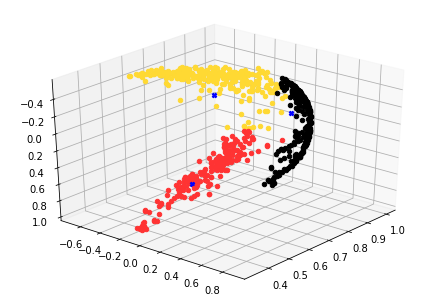

In [21]:
K = 3
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 33.84179626133344
Generation: 2 | Best fitness: 25.55165338637473
Generation: 3 | Best fitness: 25.665157365655954
Generation: 4 | Best fitness: 29.913586282857572
Generation: 5 | Best fitness: 19.104781522909896
Generation: 6 | Best fitness: 19.10478152290992
Generation: 7 | Best fitness: 23.908997528236302
Generation: 8 | Best fitness: 34.84010651083943
Generation: 9 | Best fitness: 20.71096073752414
Generation: 10 | Best fitness: 25.332337613586
Generation: 11 | Best fitness: 30.304944409587872
Generation: 12 | Best fitness: 32.77396544126527
Generation: 13 | Best fitness: 32.77396544126529


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 14 | Best fitness: 31.00803101809244
Generation: 15 | Best fitness: 30.441009934584127
Generation: 16 | Best fitness: 24.916478567755288
Generation: 17 | Best fitness: 21.9774855897245
Generation: 18 | Best fitness: 30.608214741543687
Generation: 19 | Best fitness: 19.664965681792264
Generation: 20 | Best fitness: 30.36277641699437
Generation: 21 | Best fitness: 28.41693465362495
Generation: 22 | Best fitness: 14.953263419470998
Generation: 23 | Best fitness: 18.726511070777402
Generation: 24 | Best fitness: 18.72651107077732
Generation: 25 | Best fitness: 28.963027764209034
Generation: 26 | Best fitness: 28.96302776420904


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 27 | Best fitness: 16.127778365764392
Generation: 28 | Best fitness: 14.874867406248697
Generation: 29 | Best fitness: 22.34646100812869
Generation: 30 | Best fitness: 14.621527003571833
Generation: 31 | Best fitness: 30.09890403197169
Generation: 32 | Best fitness: 30.09890403197171
Generation: 33 | Best fitness: 28.157938186895375
Generation: 34 | Best fitness: 17.86194812325779
Generation: 35 | Best fitness: 26.175417105736894
Generation: 36 | Best fitness: 26.17541710573688
Generation: 37 | Best fitness: 22.078958582615133
Generation: 38 | Best fitness: 28.952398391315484
Generation: 39 | Best fitness: 19.391829766975107
Generation: 40 | Best fitness: 19.39182976697511
Generation: 41 | Best fitness: 28.793821623635647
Generation: 42 | Best fitness: 28.793821623635708
Generation: 43 | Best fitness: 15.072863700701102
Generation: 44 | Best fitness: 13.757872686895638
Generation: 45 | Best fitness: 20.96802906055593
Generation: 46 | Best fitness: 15.449117852431112
Generat

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 91 | Best fitness: 13.049054657607106
Generation: 92 | Best fitness: 9.479073254946833
Generation: 93 | Best fitness: 9.831705387378832
Generation: 94 | Best fitness: 8.81767435989111
Generation: 95 | Best fitness: 8.855030241545911
Generation: 96 | Best fitness: 9.122169372317181
Generation: 97 | Best fitness: 9.122169372317215
Generation: 98 | Best fitness: 8.432518920601552
Generation: 99 | Best fitness: 8.766270563617546
Generation: 100 | Best fitness: 8.766270563617457
Time taken: 980.703125
DB Index        :0.694231970070049
Silhoutte Index :0.9281227744574377
Calinski-Harabasz Index :3652.0106222358077
132
113
135
155
202


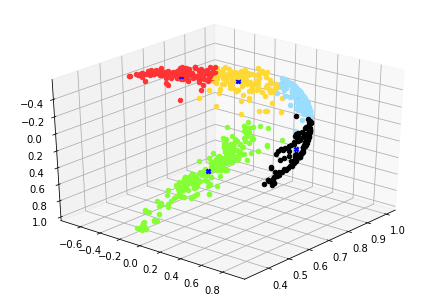

In [22]:
K = 5
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

Generation: 1 | Best fitness: 54.46877570052452


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 2 | Best fitness: 67.12930478287657


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 3 | Best fitness: 42.65073686228525
Generation: 4 | Best fitness: 48.822290041001025
Generation: 5 | Best fitness: 48.822290041001004
Generation: 6 | Best fitness: 29.41033419199056
Generation: 7 | Best fitness: 31.147093572511572
Generation: 8 | Best fitness: 37.18806883570216
Generation: 9 | Best fitness: 37.18806883570216
Generation: 10 | Best fitness: 27.796236241413137
Generation: 11 | Best fitness: 25.78059204021143


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 12 | Best fitness: 29.868940572597854
Generation: 13 | Best fitness: 41.77980423793431
Generation: 14 | Best fitness: 41.77980423793437
Generation: 15 | Best fitness: 34.534367209389536
Generation: 16 | Best fitness: 60.447828935610595
Generation: 17 | Best fitness: 60.447828935610595
Generation: 18 | Best fitness: 31.55106227445568
Generation: 19 | Best fitness: 24.46259788700448
Generation: 20 | Best fitness: 23.734384850882655
Generation: 21 | Best fitness: 49.266896305152336
Generation: 22 | Best fitness: 31.199429330026536
Generation: 23 | Best fitness: 28.033819637740706
Generation: 24 | Best fitness: 23.238710803317034
Generation: 25 | Best fitness: 30.229344392857673
Generation: 26 | Best fitness: 23.119650075304733
Generation: 27 | Best fitness: 27.564303934691964
Generation: 28 | Best fitness: 28.658221229611076
Generation: 29 | Best fitness: 28.65822122961096
Generation: 30 | Best fitness: 24.07536405127131


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 31 | Best fitness: 23.83695650910723
Generation: 32 | Best fitness: 29.320418746722726


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 33 | Best fitness: 28.76698818313684
Generation: 34 | Best fitness: 28.766988183136778
Generation: 35 | Best fitness: 26.925299141066127
Generation: 36 | Best fitness: 24.20094319904528
Generation: 37 | Best fitness: 24.200943199045263
Generation: 38 | Best fitness: 24.160259091424333
Generation: 39 | Best fitness: 25.771120576870448
Generation: 40 | Best fitness: 24.53271183174915
Generation: 41 | Best fitness: 25.131042860285415
Generation: 42 | Best fitness: 25.970500040868842
Generation: 43 | Best fitness: 25.97050004086884
Generation: 44 | Best fitness: 24.556181779956894
Generation: 45 | Best fitness: 25.58611820274138
Generation: 46 | Best fitness: 25.00199225353918
Generation: 47 | Best fitness: 25.00199225353917
Generation: 48 | Best fitness: 25.00199225353914
Generation: 49 | Best fitness: 24.51816082193984
Generation: 50 | Best fitness: 22.247578061136238
Generation: 51 | Best fitness: 18.788938375089177
Generation: 52 | Best fitness: 18.784797005876996
Generatio

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 55 | Best fitness: 18.498432150571624
Generation: 56 | Best fitness: 18.498432150571663
Generation: 57 | Best fitness: 18.418468974489667
Generation: 58 | Best fitness: 18.418468974489613
Generation: 59 | Best fitness: 17.851708505546636
Generation: 60 | Best fitness: 17.79971550667516
Generation: 61 | Best fitness: 17.799715506675188
Generation: 62 | Best fitness: 17.799715506675213
Generation: 63 | Best fitness: 19.905006691750742
Generation: 64 | Best fitness: 18.117329190272315
Generation: 65 | Best fitness: 19.28714985746494
Generation: 66 | Best fitness: 19.120183420195257
Generation: 67 | Best fitness: 19.028961096451862
Generation: 68 | Best fitness: 20.043668144906427
Generation: 69 | Best fitness: 20.260725781145727
Generation: 70 | Best fitness: 20.043668144906526
Generation: 71 | Best fitness: 20.35823098577013
Generation: 72 | Best fitness: 20.518323611960337
Generation: 73 | Best fitness: 20.518323611960295
Generation: 74 | Best fitness: 20.501396592736224
Gen

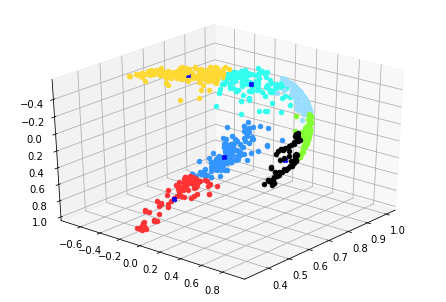

In [25]:
K = 7
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)

C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 1 | Best fitness: 65.61765352456837


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 2 | Best fitness: 41.62176729118789
Generation: 3 | Best fitness: 63.40628286442323
Generation: 4 | Best fitness: 63.40628286442319
Generation: 5 | Best fitness: 38.93382531448066
Generation: 6 | Best fitness: 60.243225288418685


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 7 | Best fitness: 79.5058973259789
Generation: 8 | Best fitness: 79.50589732597895
Generation: 9 | Best fitness: 38.2767888057811


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 10 | Best fitness: 36.953771207084664
Generation: 11 | Best fitness: 32.54568878628093
Generation: 12 | Best fitness: 36.39890429619075
Generation: 13 | Best fitness: 65.9940896022425


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 14 | Best fitness: 71.31324473169855
Generation: 15 | Best fitness: 33.67539660892557
Generation: 16 | Best fitness: 33.04938518256749
Generation: 17 | Best fitness: 36.65013039751941
Generation: 18 | Best fitness: 72.47713256664551


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 19 | Best fitness: 42.04483772980551


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 20 | Best fitness: 34.076104616259116
Generation: 21 | Best fitness: 37.57300332746306
Generation: 22 | Best fitness: 57.44070564518312
Generation: 23 | Best fitness: 89.71497174092649
Generation: 24 | Best fitness: 89.71497174092643
Generation: 25 | Best fitness: 65.50680515497702
Generation: 26 | Best fitness: 65.73248414468539
Generation: 27 | Best fitness: 56.90985666369877
Generation: 28 | Best fitness: 81.12588016224377
Generation: 29 | Best fitness: 74.56506079251339
Generation: 30 | Best fitness: 72.53331501884607
Generation: 31 | Best fitness: 72.53331501884607
Generation: 32 | Best fitness: 65.79628418441774


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 33 | Best fitness: 46.431952496897345
Generation: 34 | Best fitness: 70.34146433937389


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 35 | Best fitness: 68.77510230406439


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var
C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 36 | Best fitness: 68.77510230406446
Generation: 37 | Best fitness: 41.7848028747431
Generation: 38 | Best fitness: 72.34030827913344
Generation: 39 | Best fitness: 72.34030827913345
Generation: 40 | Best fitness: 34.38239680353607
Generation: 41 | Best fitness: 65.68200837264885
Generation: 42 | Best fitness: 55.45612628934606
Generation: 43 | Best fitness: 63.801609607996994
Generation: 44 | Best fitness: 32.366809830330745
Generation: 45 | Best fitness: 31.554894539534533
Generation: 46 | Best fitness: 35.170777107866876
Generation: 47 | Best fitness: 34.317772258162876
Generation: 48 | Best fitness: 33.76163042320365
Generation: 49 | Best fitness: 32.704944370255475
Generation: 50 | Best fitness: 30.63554040893608
Generation: 51 | Best fitness: 30.442181710179785
Generation: 52 | Best fitness: 30.442181710180048
Generation: 53 | Best fitness: 29.67634003781615
Generation: 54 | Best fitness: 29.676340037816026
Generation: 55 | Best fitness: 32.74012101738176


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 56 | Best fitness: 33.64582837860312
Generation: 57 | Best fitness: 32.37978834497454
Generation: 58 | Best fitness: 31.17040886820037
Generation: 59 | Best fitness: 31.17040886820038
Generation: 60 | Best fitness: 30.305108634079787
Generation: 61 | Best fitness: 29.613894744864325
Generation: 62 | Best fitness: 29.559977697176578
Generation: 63 | Best fitness: 25.97093296584043
Generation: 64 | Best fitness: 25.380376039902366
Generation: 65 | Best fitness: 26.121011752747574
Generation: 66 | Best fitness: 26.045253886092098
Generation: 67 | Best fitness: 25.556584304832313
Generation: 68 | Best fitness: 25.28457358065693


C:\Users\Hp\Anaconda3\lib\site-packages\sklearn\decomposition\truncated_svd.py:191: RuntimeWarning: invalid value encountered in true_divide
  self.explained_variance_ratio_ = exp_var / full_var


Generation: 69 | Best fitness: 24.297366268480705
Generation: 70 | Best fitness: 24.38552098266813
Generation: 71 | Best fitness: 24.385520982668112
Generation: 72 | Best fitness: 23.77964214902806
Generation: 73 | Best fitness: 24.50339324868476
Generation: 74 | Best fitness: 24.4426342381644
Generation: 75 | Best fitness: 24.442634238164015
Generation: 76 | Best fitness: 24.576952995705657
Generation: 77 | Best fitness: 24.905317752581055
Generation: 78 | Best fitness: 28.62691311709254
Generation: 79 | Best fitness: 28.62691311709241
Generation: 80 | Best fitness: 28.530951457697196
Generation: 81 | Best fitness: 28.49828152854659
Generation: 82 | Best fitness: 28.498281528546627
Generation: 83 | Best fitness: 28.498281528546627
Generation: 84 | Best fitness: 28.49828152854662
Generation: 85 | Best fitness: 28.498281528546723
Generation: 86 | Best fitness: 28.498281528546723
Generation: 87 | Best fitness: 28.498281528546613
Generation: 88 | Best fitness: 28.49828152854658
Generation

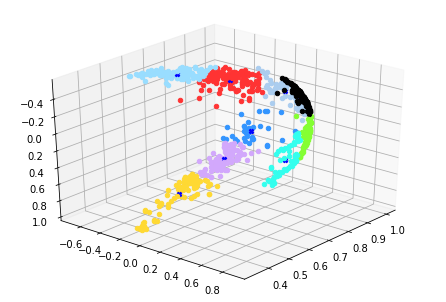

In [24]:
K = 9
chromosome = main_func()
print("DB Index        :"+str(davies_bouldin_index(chromosome)))
print("Silhoutte Index :"+str(silhoutette_index(chromosome)))
print("Calinski-Harabasz Index :"+str(calinski_harabasz(chromosome)))
plot(chromosome)